1. ```Найдите данные о цене любого биржевого актива
    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 
    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной```

Выбрал данные о цене Белуги(продает водку) за c 2016 по 2020 год.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller 
from itertools import product 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
file_name = 'BELU.csv'
df = pd.read_csv(file_name)
print(f'shape: {df.shape}')
df.head(5)

shape: (777, 9)


,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,BELU,D,20170929,0,611,619,610,615,20
1,BELU,D,20171002,0,622,625,606,618,277
2,BELU,D,20171003,0,610,617,610,611,1039
3,BELU,D,20171004,0,613,619,613,619,2
4,BELU,D,20171005,0,618,619,618,619,27


In [3]:
df.tail(5)

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
772,BELU,D,20201221,0,1392,1392,1356,1358,3960
773,BELU,D,20201222,0,1356,1366,1345,1350,4040
774,BELU,D,20201223,0,1377,1377,1350,1360,2770
775,BELU,D,20201224,0,1361,1361,1350,1350,876
776,BELU,D,20201225,0,1334,1359,1334,1358,1203


```Предобработайте данные```

Будем предскаывать ```HIGH```. ```DATE``` оставил для наглядности. Данные начинаются с пятницы. Чтобы сохранить недели - удалим первый день.

In [4]:
df.drop(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<LOW>', '<CLOSE>', '<VOL>'], axis=1, inplace=True)
df.drop(df.head(1).index, inplace=True)
print(df.shape)
df.head()

(776, 2)


,<DATE>,<HIGH>
1,20171002,625
2,20171003,617
3,20171004,619
4,20171005,619
5,20171006,626


```Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам```

In [5]:
weeks = len(df) // 5
weeks_per_year = 52
years = weeks / weeks_per_year
print(weeks)
print(years)
df.head(2)

155
2.980769230769231


,<DATE>,<HIGH>
1,20171002,625
2,20171003,617


Сожмем данные по за каждые 5 поряд идущих дней в 1

In [6]:
weeks = int(weeks)
high_per_week = [max([df['<HIGH>'][i+j] for j in range(5)]) for i in range(1, weeks * 5, 5)]
df_week=pd.DataFrame(pd.Series(high_per_week, name='High', index=df.index[:weeks]))

print(f'shape:{df_week.shape}')
df_week.head()

shape:(155, 1)


,High
1,626
2,662
3,649
4,682
5,639


```Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы```

<AxesSubplot:title={'center':'Residual'}>

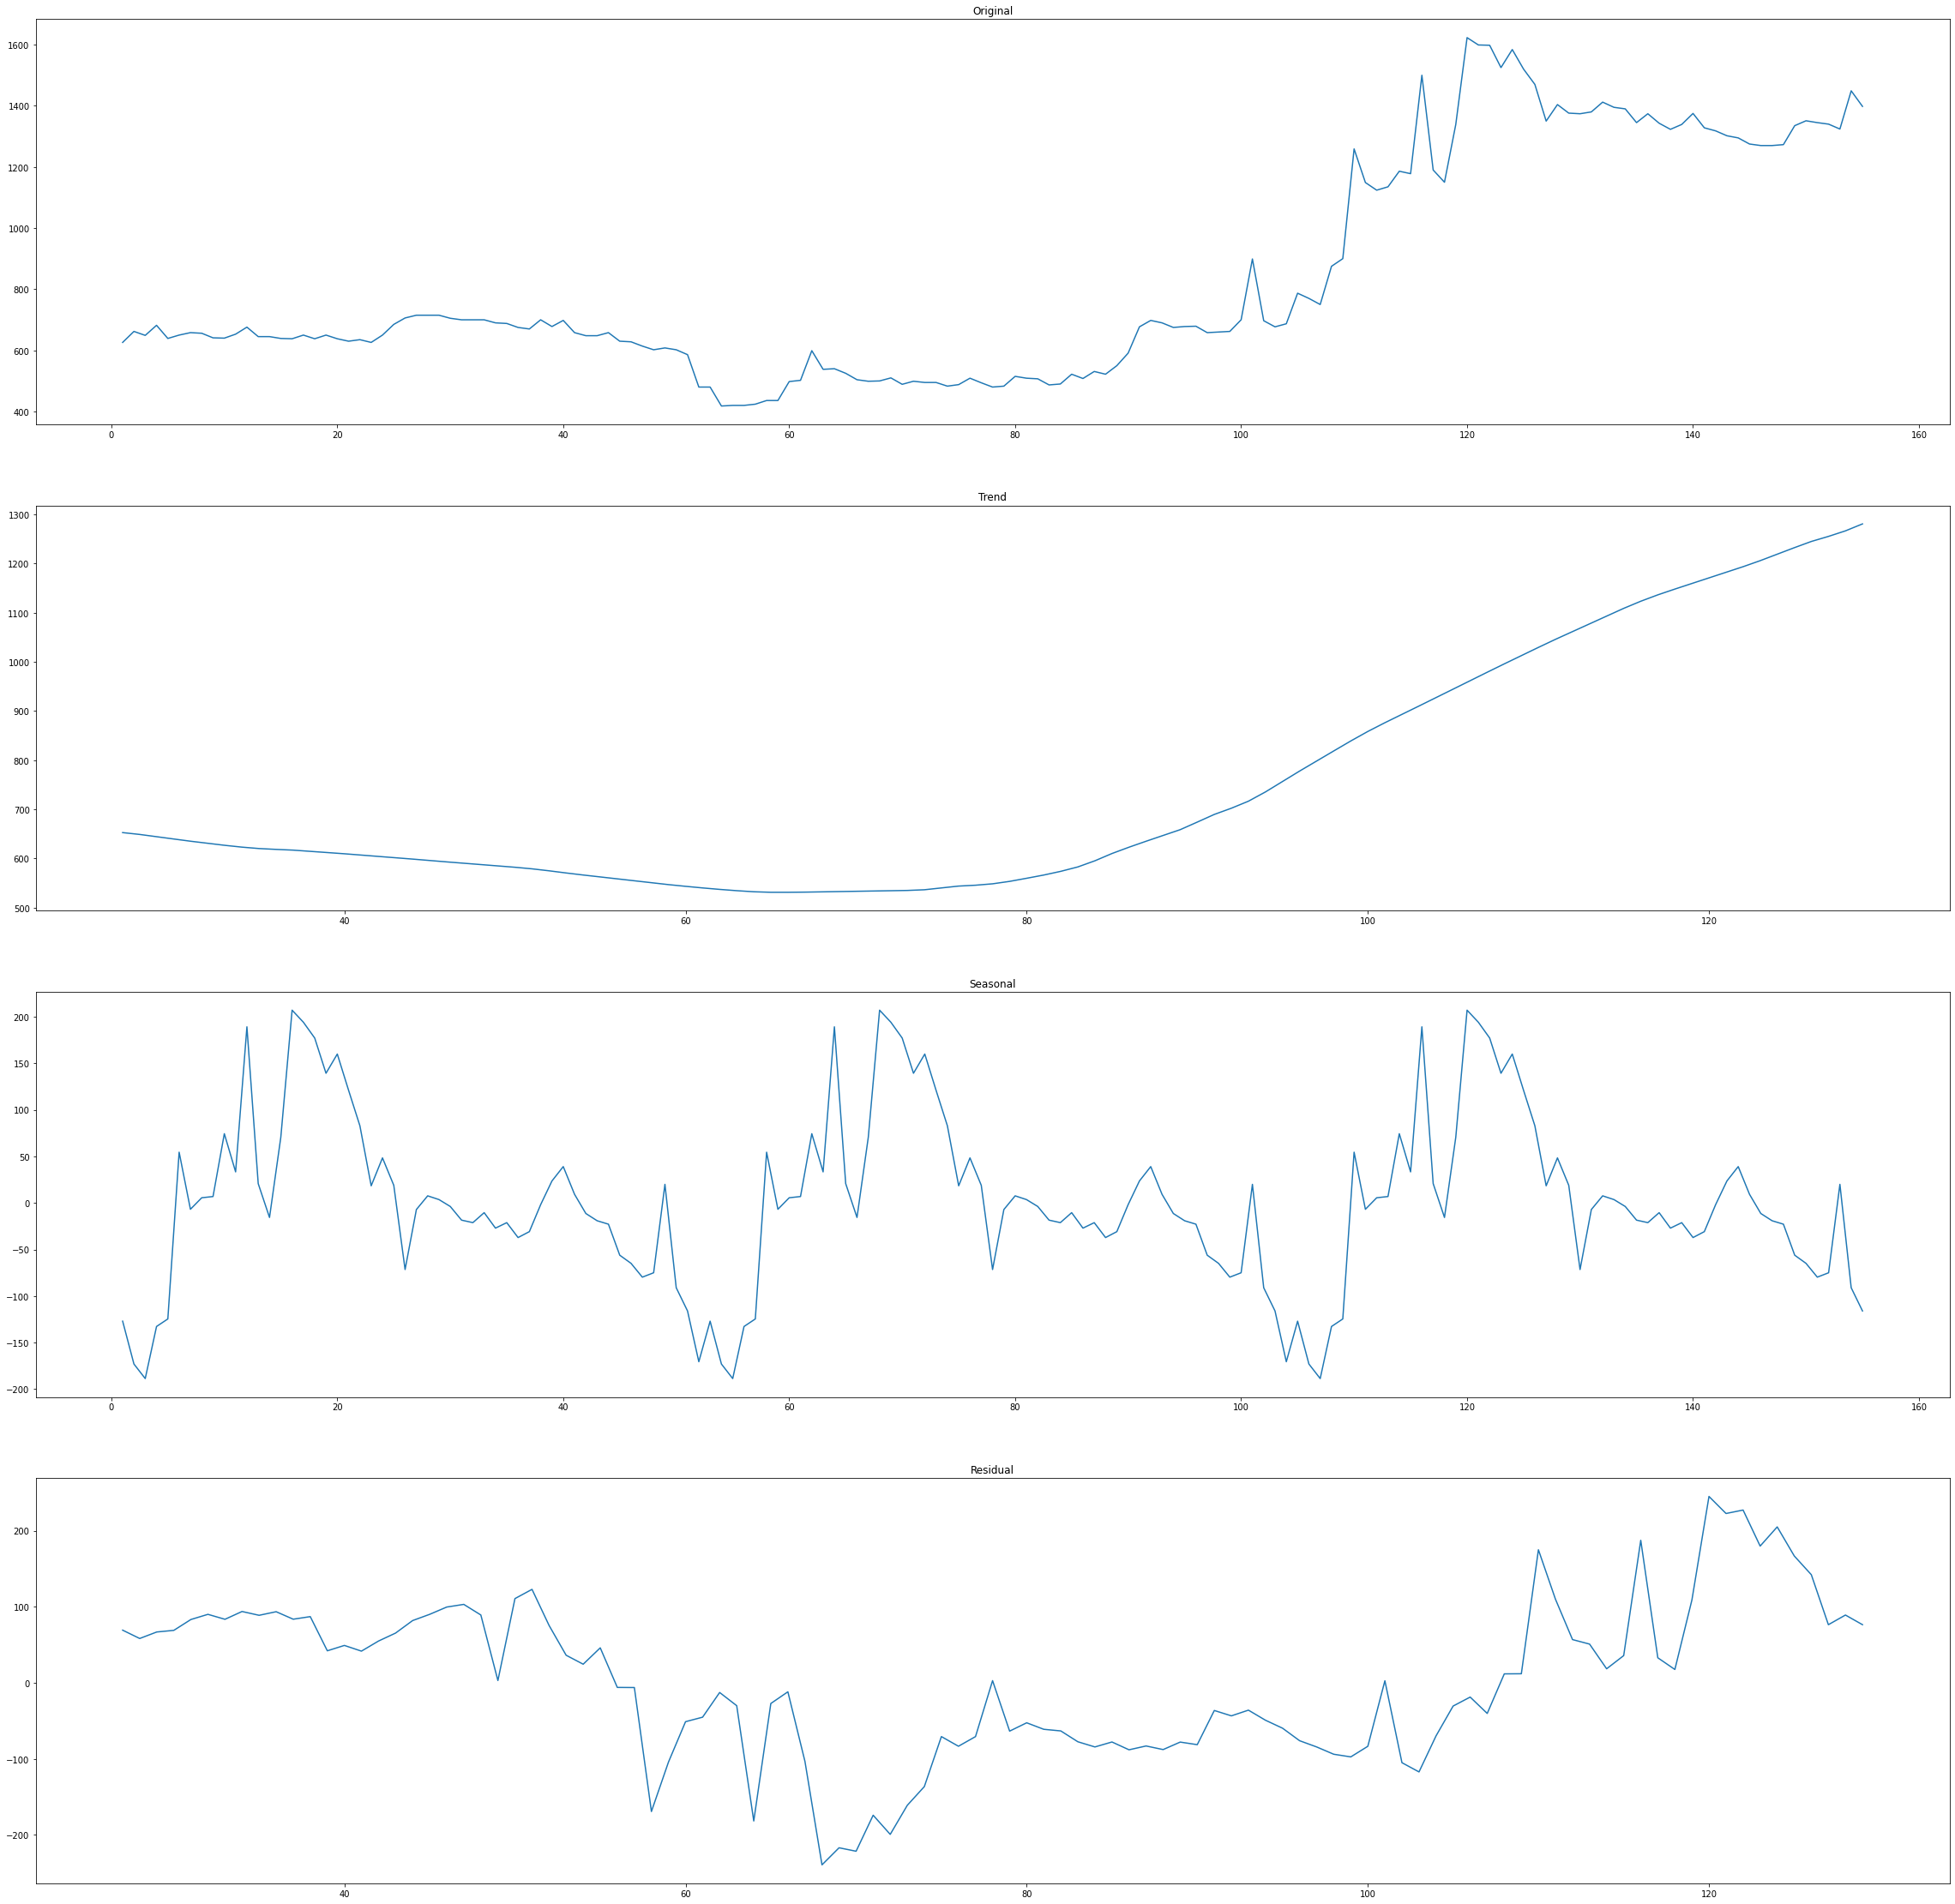

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(40, 40))
decompose = seasonal_decompose(df_week[['High']], period=weeks_per_year) # 

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2]) 
decompose.resid.plot(ax=ax[3]) 

In [8]:
p_value = adfuller(df_week['High'])[1]
print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
f'{round(p_value, 4)} > 0.05. Ряд не стационарный!')

Полученный уровень значимости (p-value): 0.7708. 0.7708 > 0.05. Ряд не стационарный!


In [9]:
df_week['HighLog'] = np.log(df_week['High'])
df_week['HighLogDiff_1'] = df_week['HighLog'] - df_week['HighLog'].shift(1)

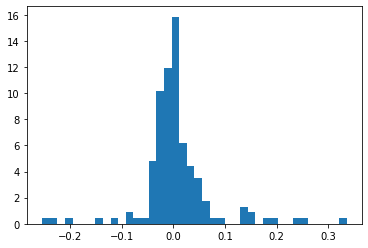

In [10]:
plt.hist(df_week['HighLogDiff_1'][1:], density=True, bins=40);

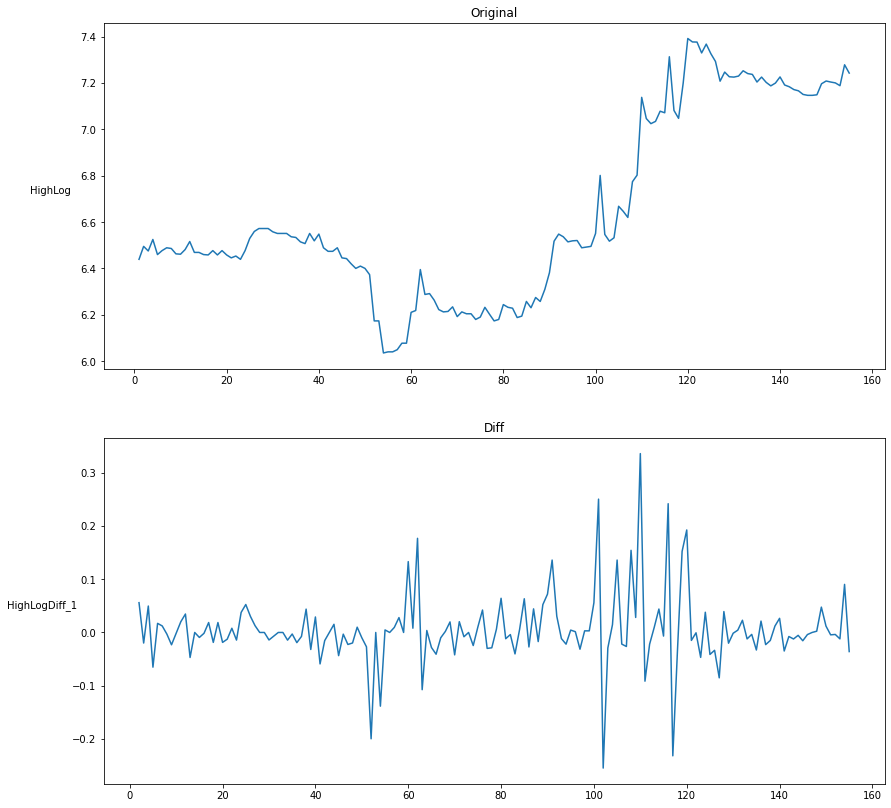

In [11]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('HighLog', rotation=0, labelpad=30)
df_week['HighLog'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('HighLogDiff_1', rotation=0, labelpad=30)
df_week['HighLogDiff_1'].plot(ax=ax);

In [12]:
p_value = adfuller(df_week["HighLogDiff_1"][1:])[1]

print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. По мнению теста ряд стационарен!')

Полученный уровень значимости (p-value): 0.0171. 0.0171 < 0.05. По мнению теста ряд стационарен!


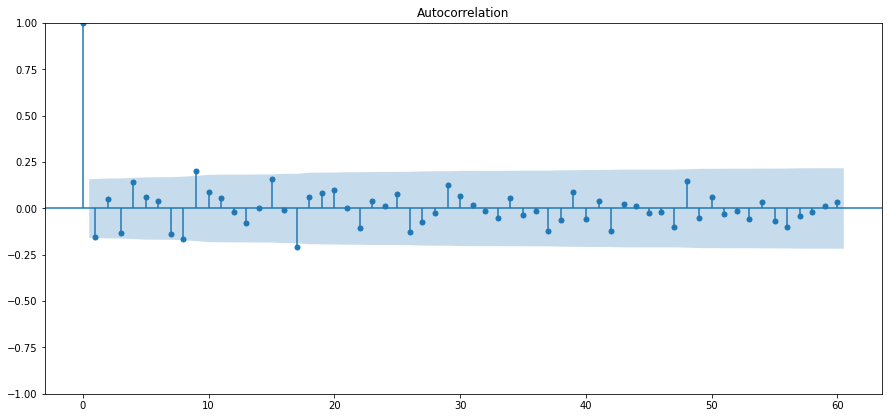

In [13]:
# Построим корелограмму и проверим наличие значимых коррелаций
plt.figure(figsize=(15, 15))

ax = plt.subplot(212)
plot_acf(df_week['HighLogDiff_1'][1:], lags=60, ax=ax);

Засплитим на тренировочные и тестовые данные 80-20

In [14]:
df_train, df_test = train_test_split(df_week, test_size=0.2, shuffle=False)

In [15]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [16]:
%%time

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df_train['HighLog'], 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 52)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


  0%|                                                    | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|▋                                           | 1/64 [00:42<45:02, 42.90s/it]/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueW

 20%|████████▏                               | 13/64 [20:59<1:42:56, 121.10s/it]/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 22%|███████▋                           | 14/64 [9:02:25<132:25:14, 9534.29s/it]/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ign

 41%|███████████████▍                      | 26/64 [9:25:45<2:43:28, 258.12s/it]/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 42%|████████████████                      | 27/64 [9:29:19<2:31:00, 244.88s/it]/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.

KeyboardInterrupt: 

In [25]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
24  (2, 3, 3, 1) -118.568873
28  (2, 4, 3, 1) -117.190983
22  (2, 2, 4, 1) -117.011625
25  (2, 3, 3, 2) -116.560724
21  (2, 2, 3, 2) -116.340315


In [26]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              HighLog   No. Observations:                  124
Model:             SARIMAX(2, 1, 3)x(3, 1, [1], 52)   Log Likelihood                  69.284
Date:                              Wed, 29 Dec 2021   AIC                           -118.569
Time:                                      18:02:34   BIC                            -95.942
Sample:                                           0   HQIC                          -109.571
                                              - 124                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8748      0.280      3.125      0.002       0.326       1.424
ar.L2         -0.68

Проверяим, что остатки не стационарны и не автокоррелируемы

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. По мнению теста ряд стационарен!


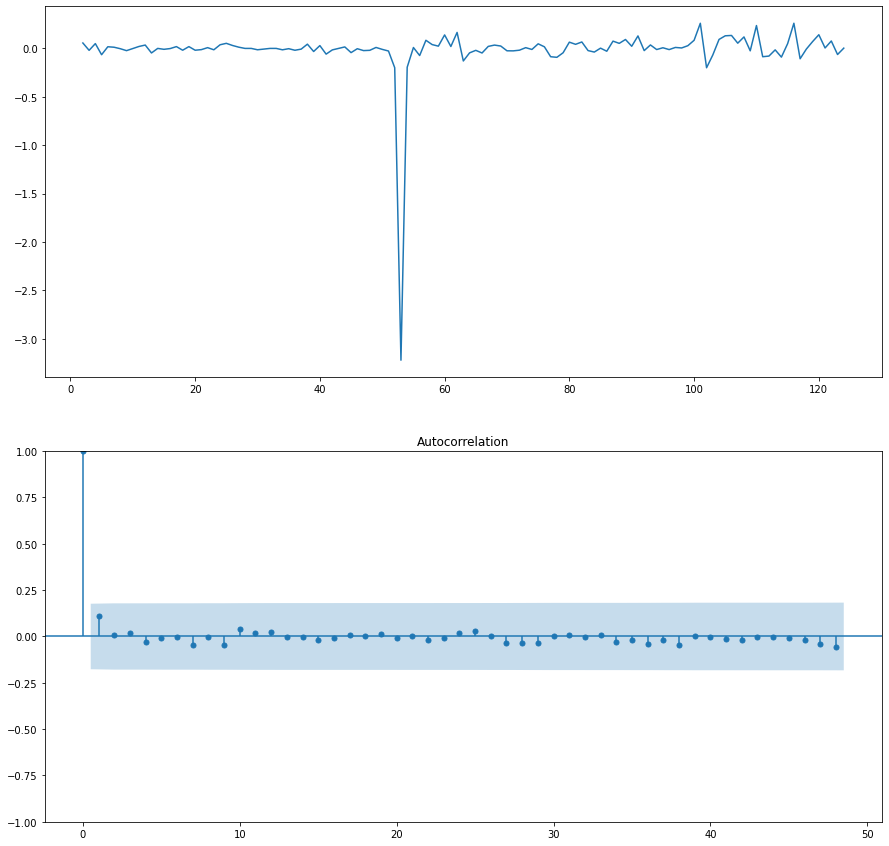

In [27]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[1:].plot() 

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax)

p_value = adfuller(best_model.resid[1:][1:])[1]

print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. По мнению теста ряд стационарен!')

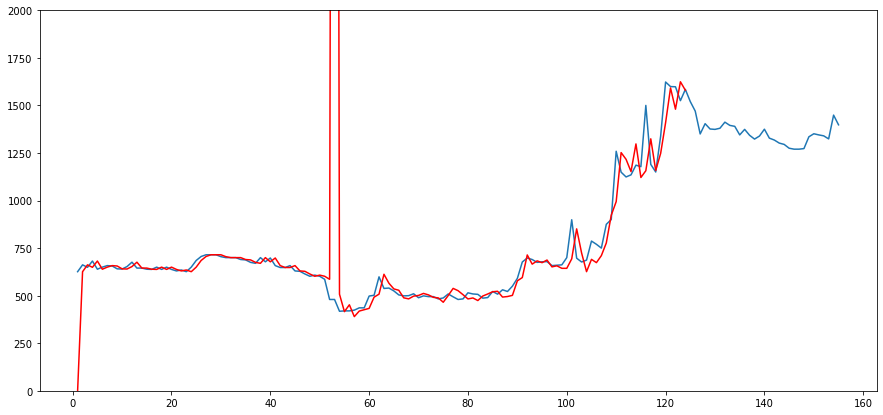

In [28]:
df_week['Model'] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))

df_week['High'].plot(ylim=[0, 2000])
df_week['Model'].plot(c='r');

In [29]:
predict_len = len(df_test)
new_close_value = df_week[['High', 'Model']]

new_close_value.tail()

,High,Model
151,1345,NaN
152,1340,NaN
153,1324,NaN
154,1449,NaN
155,1398,NaN


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/tmp/ipykernel_5918/3231400847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_close_value['Model'] = np.exp(best_model.predict(start=data_start, end=data_end))


124


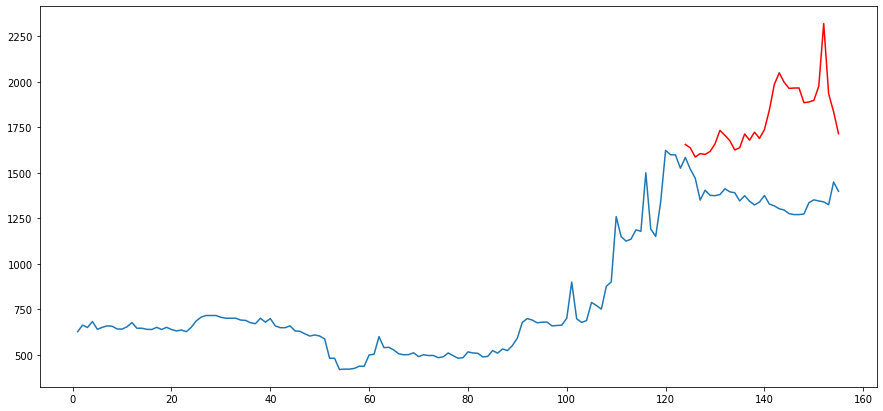

In [30]:
data_start = len(df_train)
data_end = len(df_train) + predict_len

new_close_value['Model'] = np.exp(best_model.predict(start=data_start, end=data_end))

plt.figure(figsize=(15,7))
new_close_value['High'].plot()
new_close_value['Model'].plot(c='r');

print(len(df_train))

In [31]:
new_close_value.tail(predict_len)

,High,Model
125,1520,1636.597645
126,1470,1586.497085
127,1350,1605.060064
128,1404,1600.995253
129,1376,1617.013897
130,1374,1658.852577
131,1380,1733.059349
132,1412,1705.977700
133,1395,1676.516354
134,1390,1625.466063


In [33]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(new_close_value['High'][data_start:data_end], new_close_value['Model'][data_start:data_end])

0.3338520317728825